In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random

train_dir = os.getcwd() + "/../train/"
train_files = os.listdir(train_dir)

bad_imgs_path = os.path.join(os.getcwd(), "badimgs.txt")
with open(bad_imgs_path, "r") as f:
    bad_imgs = {line.strip() for line in f if line.strip()}

# UTILS

def get_rand_img_path():
    return train_dir + random.choice(train_files)

def get_img(label):
    path = os.path.join(train_dir,f"{label}-0.png")
    img = cv2.imread(path)
    return img

def get_label(img_path):
    filename = os.path.basename(img_path)
    label = filename.split('-')[0]
    return label

def get_rand_img():
    path = get_rand_img_path()
    label = get_label(path)
    img = cv2.imread(path)
    return img, label

def show_img(img, title=None):
    plt.figure()
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def remove_lines(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV)
    
    # Remove lines
    removed = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)
    
    return removed

In [2]:
def segment_by_stroke_width(img_bgr, min_width=2, max_width=10):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3,3), 0)

    # 1. Edge detection
    edges = cv2.Canny(gray, 80, 150)

    # 2. Distance transform on inverted edges
    dist = cv2.distanceTransform(255 - edges, cv2.DIST_L2, 3)

    # 3. Threshold by width range
    # scale factor 2 because distance transform ≈ half the stroke width
    mask = ((dist >= min_width/2) & (dist <= max_width/2)).astype(np.uint8) * 255

    # 4. Morphological cleanup
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    # 5. Connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    h, w = gray.shape
    boxes = []
    for i in range(1, num_labels):
        x, y, bw, bh, area = stats[i]
        if area > 50 and bh > h*0.2:
            boxes.append((x, y, bw, bh))
    boxes.sort(key=lambda r: r[0])

    # 6. Visualization
    vis = img_bgr.copy()
    for (x, y, bw, bh) in boxes:
        cv2.rectangle(vis, (x, y), (x+bw, y+bh), (0,255,0), 2)

    return vis, mask, boxes

def extract_characters_from_boxes(img, boxes, out_size=(64, 64), pad_ratio=0.25):
    chars = []

    for (x, y, bw, bh) in boxes:
        # Crop region
        crop = img[y:y+bh, x:x+bw]

        # Compute padding (as fraction of max dimension)
        max_side = max(bw, bh)
        pad = int(max_side * pad_ratio)

        # Pad evenly on all sides
        crop_padded = cv2.copyMakeBorder(
            crop,
            pad, pad, pad, pad,
            cv2.BORDER_CONSTANT,
            value=[255, 255, 255]  # white background
        )

        # Resize to standard size (e.g., 64×64)
        crop_resized = cv2.resize(crop_padded, out_size, interpolation=cv2.INTER_AREA)
        chars.append(crop_resized)

    return chars

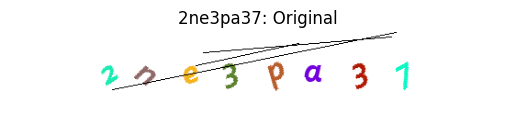

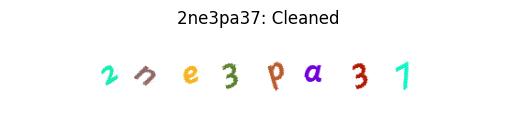

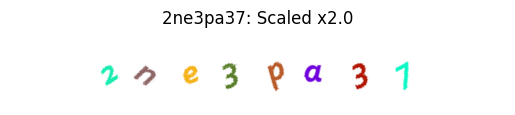

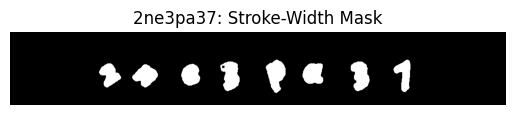

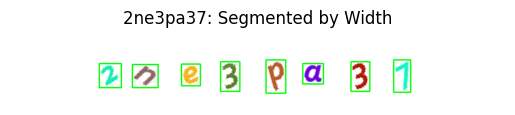

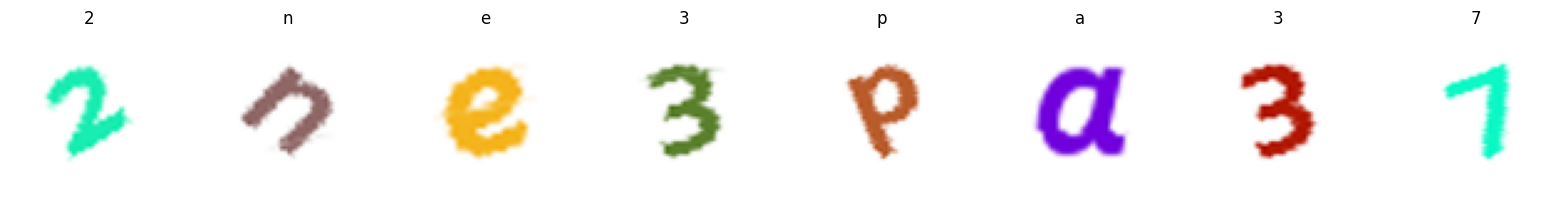

Number of characters expected: 8
Number of characters extracted: 8


In [3]:
img, label = get_rand_img()
show_img(img, title=f"{label}: Original")

img_clean = remove_lines(img)
show_img(img_clean, title=f"{label}: Cleaned")

scale = 2.0  # try 2× first, or 3× if the original CAPTCHA is small
img_scaled = cv2.resize(img_clean, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
show_img(img_scaled, title=f"{label}: Scaled x{scale}")

vis, mask, boxes = segment_by_stroke_width(img_scaled, min_width=2, max_width=8)
show_img(mask, title=f"{label}: Stroke-Width Mask")
show_img(vis, title=f"{label}: Segmented by Width")

# --- Extract individual, padded, same-size characters ---
chars = extract_characters_from_boxes(img_scaled, boxes, out_size=(64,64))

# --- Plot the extracted characters ---
n = len(chars)
cols = min(n, 8)
rows = (n + cols - 1) // cols

plt.figure(figsize=(cols*2, rows*2))
for i, ch in enumerate(chars):
    plt.subplot(rows, cols, i+1)
    if len(ch.shape) == 2:
        plt.imshow(ch, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(ch, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    if i < len(label):
        plt.title(label[i])
plt.tight_layout()
plt.show()

expected_len = len(label)
extracted_len = len(chars)

print("Number of characters expected:", expected_len)
print("Number of characters extracted:", extracted_len)

In [4]:
def stroke_width_pipeline(img):

    img_clean = remove_lines(img)

    vis, mask, boxes = segment_by_stroke_width(img_clean, min_width=2, max_width=8)

    chars = extract_characters_from_boxes(img_clean, boxes, out_size=(64,64))

    return chars

In [ ]:
results = [0, 0]

for f in train_files:
    if f not in bad_imgs:
        img = cv2.imread(train_dir + f)
        chars = stroke_width_pipeline(img)
        if len(chars) == len(f[:-6]):
            results[0] += 1
        else:
            results[1] += 1

print(results, results[0]/sum(results))

[4127, 3773] 0.5224050632911392


## Higher Contrast & Upscaling

In [7]:
def segment_by_stroke_width_robust(img, min_width=2, max_width=8, out_size=(32,32), pad_ratio=0.25):
    """
    Robust stroke-width + color-based segmentation.
    Returns:
        boxes: list of bounding boxes (x,y,w,h)
        chars: list of extracted, padded, resized character images
    """
    # 1. Upscale handled outside if needed; assume img is already scaled
    img_scaled = img.copy()
    h, w = img_scaled.shape[:2]
    
    # 2. Convert to perceptual grayscale and apply CLAHE
    gray = cv2.cvtColor(img_scaled, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    # 3. Stroke-width mask (edges + distance transform)
    edges = cv2.Canny(gray, 80, 150)
    dist = cv2.distanceTransform(255 - edges, cv2.DIST_L2, 3)
    mask_sw = ((dist >= min_width/2) & (dist <= max_width/2)).astype(np.uint8) * 255
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    mask_sw = cv2.morphologyEx(mask_sw, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask_sw = cv2.morphologyEx(mask_sw, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # 4. Color-based mask for light colors (yellow / pale tones)
    b, g, r = cv2.split(img_scaled)
    mask_color = ((r > 150) & (g > 150) & (b < 120)).astype(np.uint8) * 255  # yellowish
    mask_color = cv2.morphologyEx(mask_color, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    # 5. Merge masks
    final_mask = cv2.bitwise_or(mask_sw, mask_color)
    
    # 6. Connected components -> bounding boxes
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(final_mask, connectivity=8)
    boxes = []
    for i in range(1, num_labels):
        x, y, bw, bh, area = stats[i]
        if area > 50 and bh > h * 0.2:
            boxes.append((x, y, bw, bh))
    boxes.sort(key=lambda r: r[0])
    
    # 8. Extract characters (from original image, padded, resized)
    chars = []
    for (x, y, bw, bh) in boxes:
        crop = img_scaled[y:y+bh, x:x+bw]
        max_side = max(bw, bh)
        pad = int(max_side * pad_ratio)
        crop_padded = cv2.copyMakeBorder(crop, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=[255,255,255])
        crop_resized = cv2.resize(crop_padded, out_size, interpolation=cv2.INTER_AREA)
        chars.append(crop_resized)
    
    return final_mask, boxes, chars

In [12]:
def stroke_width_robust_pipeline(img):

    img_clean = remove_lines(img)
    scale = 2.0
    img_scaled = cv2.resize(img_clean, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    mask, boxes, chars = segment_by_stroke_width_robust(img_clean, min_width=2, max_width=8, out_size=(64, 64))

    return chars

In [13]:
results = [0, 0]

for f in train_files:
    if f not in bad_imgs:
        img = cv2.imread(train_dir + f)
        chars = stroke_width_robust_pipeline(img)
        if len(chars) == len(f[:-6]):
            results[0] += 1
        else:
            results[1] += 1

print(results, results[0]/sum(results))

[4822, 3078] 0.610379746835443
